In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import colorcet as cc

/home/tnoel/anaconda3/envs/myenv_39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
ep_ad = sc.read_h5ad('epithelial_l_ad.h5ad')
sig_d = np.load('pathway_signature_d.npy',allow_pickle=True).item()

### Pathway/Module scoring and statistics

In [3]:
for key,item in sig_d.items():
    sc.tl.score_genes(ep_ad,item,score_name=f'{key}_score',use_raw=False)

In [5]:
#sig_tf_modules = pd.read_csv('sig_tf_modules.csv',index_col=0)
sig_tf_modules = pd.read_csv('/local-data/tnoel/Ellis_snRNA/no_epz1_2/epithelial_palantir/params3/sig_tf_modules.csv',index_col=0)
for module in sig_tf_modules.tf_module.unique():
    module_tfs = [x.replace('*','') for x in sig_tf_modules.query("tf_module==@module").tf.unique().tolist()]
    sc.tl.score_genes(ep_ad,module_tfs,score_name=f'tf_module{module}_score',use_raw=False)

In [7]:
select = [x for x in ep_ad.obs.columns if 'score' in x]
mtx = ep_ad.obs[select].copy()
mtx['subtype'] = ep_ad.obs['subtype']
mtx_avg = mtx.groupby('subtype').mean()

/tmp/ipykernel_64143/3633002533.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mtx_avg = mtx.groupby('subtype').mean()


In [8]:
sig_de = []
for sig_name in [x for x in mtx.columns if x!='subtype']:
    for subtype in np.unique(ep_ad.obs['subtype']):
        pval = mannwhitneyu(mtx.query("subtype==@subtype")[sig_name],mtx.query("subtype!=@subtype")[sig_name],alternative='greater')[1]
        sig_de.append([sig_name,subtype,pval])
sig_de = pd.DataFrame(sig_de,columns=['pathway','subtype','pval'])

In [9]:
module_names = ['tf_module0_score','tf_module1_score','tf_module2_score']
sig_de['annot'] = ['*' if x < .05 else '' for x in sig_de['pval']]
annot = sig_de.pivot(columns='pathway',index='subtype',values='annot')
annot = annot.loc[mtx_avg.index.tolist(),mtx_avg.columns.tolist()]

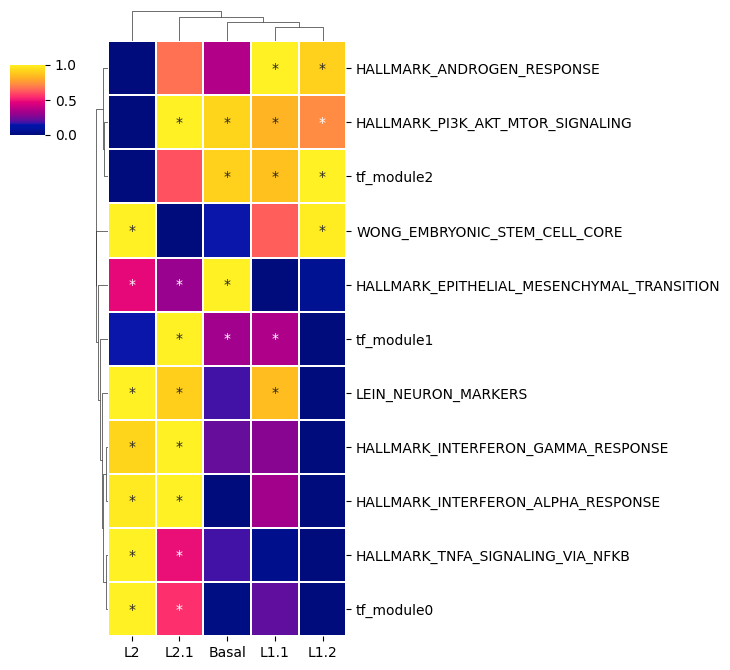

In [10]:
g = sns.clustermap(mtx_avg.T,lw=.01,standard_scale=0,cmap=sns.color_palette(cc.bmy),dendrogram_ratio=(.05,.05),figsize=(7,7),annot=annot.T,fmt='')
ax = g.ax_heatmap
ax.set_xlabel('')
g.ax_cbar.set_position((-.1, .8, .05, .1))
ax.set_yticklabels([x.get_text().replace('_score','') for x in ax.get_yticklabels()])
plt.show()

### Violin plots

In [11]:
sig_annot_d = {}
for sig_name in np.unique(sig_de['pathway']):
    annot = ['*' if x < .05 else '' for x in sig_de.query("pathway==@sig_name")['pval']]
    sig_annot_d[sig_name] = annot

In [12]:
sig_annot_d

{'HALLMARK_ANDROGEN_RESPONSE_score': ['', '*', '*', '', ''],
 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION_score': ['*', '', '', '*', '*'],
 'HALLMARK_INTERFERON_ALPHA_RESPONSE_score': ['', '', '', '*', '*'],
 'HALLMARK_INTERFERON_GAMMA_RESPONSE_score': ['', '', '', '*', '*'],
 'HALLMARK_PI3K_AKT_MTOR_SIGNALING_score': ['*', '*', '*', '', '*'],
 'HALLMARK_TNFA_SIGNALING_VIA_NFKB_score': ['', '', '', '*', '*'],
 'LEIN_NEURON_MARKERS_score': ['', '*', '', '*', '*'],
 'WONG_EMBRYONIC_STEM_CELL_CORE_score': ['', '', '*', '*', ''],
 'tf_module0_score': ['', '', '', '*', '*'],
 'tf_module1_score': ['*', '*', '', '', '*'],
 'tf_module2_score': ['*', '*', '*', '', '']}

/tmp/ipykernel_64143/2270386978.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.violinplot(mtx,y='{}_score'.format(sig_name),x='subtype',palette=sns.color_palette('Dark2_r'))
/tmp/ipykernel_64143/2270386978.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  g=sns.violinplot(mtx,y='{}_score'.format(sig_name),x='subtype',palette=sns.color_palette('Dark2_r'))
/tmp/ipykernel_64143/2270386978.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(),rotation=90)


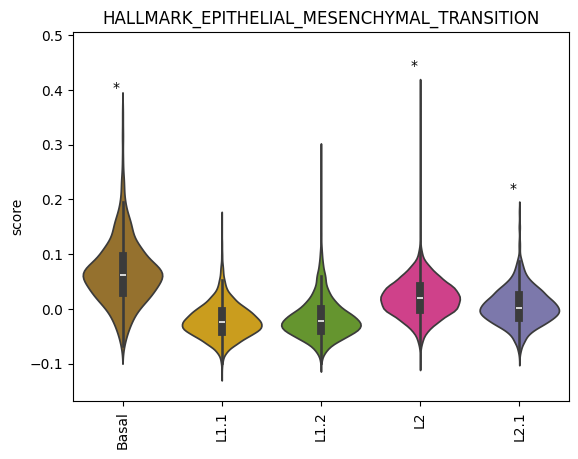

/tmp/ipykernel_64143/2270386978.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.violinplot(mtx,y='{}_score'.format(sig_name),x='subtype',palette=sns.color_palette('Dark2_r'))
/tmp/ipykernel_64143/2270386978.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  g=sns.violinplot(mtx,y='{}_score'.format(sig_name),x='subtype',palette=sns.color_palette('Dark2_r'))
/tmp/ipykernel_64143/2270386978.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(),rotation=90)


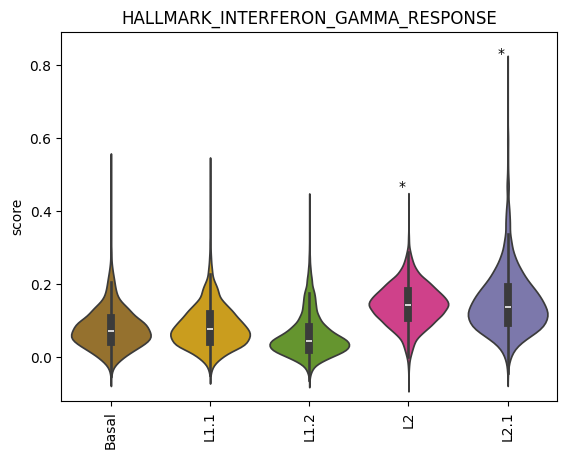

/tmp/ipykernel_64143/2270386978.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.violinplot(mtx,y='{}_score'.format(sig_name),x='subtype',palette=sns.color_palette('Dark2_r'))
/tmp/ipykernel_64143/2270386978.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  g=sns.violinplot(mtx,y='{}_score'.format(sig_name),x='subtype',palette=sns.color_palette('Dark2_r'))
/tmp/ipykernel_64143/2270386978.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(),rotation=90)


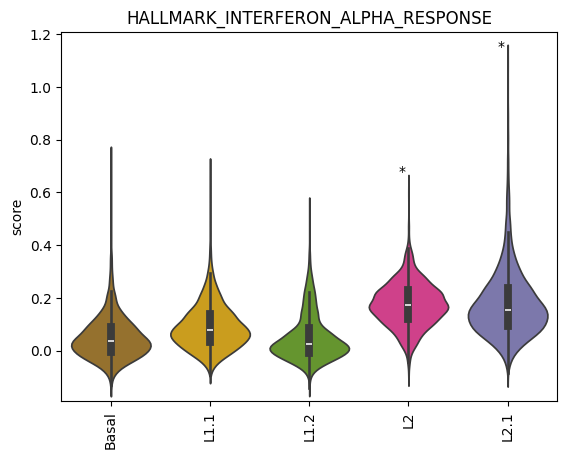

/tmp/ipykernel_64143/2270386978.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.violinplot(mtx,y='{}_score'.format(sig_name),x='subtype',palette=sns.color_palette('Dark2_r'))
/tmp/ipykernel_64143/2270386978.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  g=sns.violinplot(mtx,y='{}_score'.format(sig_name),x='subtype',palette=sns.color_palette('Dark2_r'))
/tmp/ipykernel_64143/2270386978.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(),rotation=90)


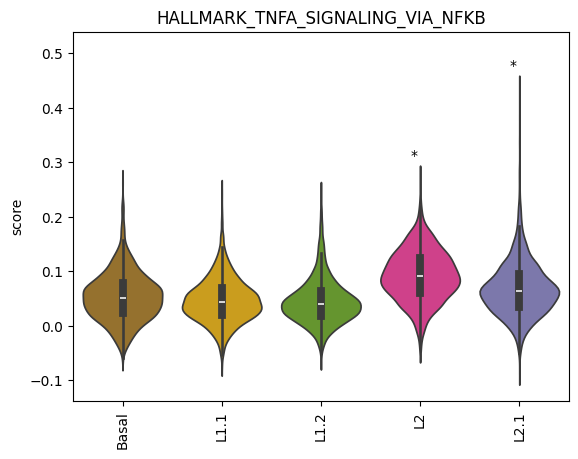

/tmp/ipykernel_64143/2270386978.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.violinplot(mtx,y='{}_score'.format(sig_name),x='subtype',palette=sns.color_palette('Dark2_r'))
/tmp/ipykernel_64143/2270386978.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  g=sns.violinplot(mtx,y='{}_score'.format(sig_name),x='subtype',palette=sns.color_palette('Dark2_r'))
/tmp/ipykernel_64143/2270386978.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(),rotation=90)


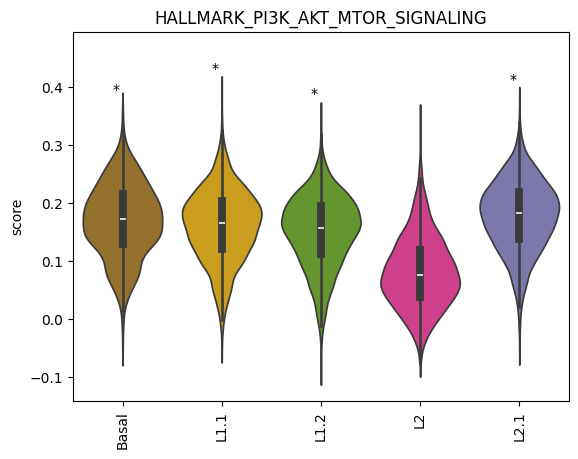

/tmp/ipykernel_64143/2270386978.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.violinplot(mtx,y='{}_score'.format(sig_name),x='subtype',palette=sns.color_palette('Dark2_r'))
/tmp/ipykernel_64143/2270386978.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  g=sns.violinplot(mtx,y='{}_score'.format(sig_name),x='subtype',palette=sns.color_palette('Dark2_r'))
/tmp/ipykernel_64143/2270386978.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(),rotation=90)


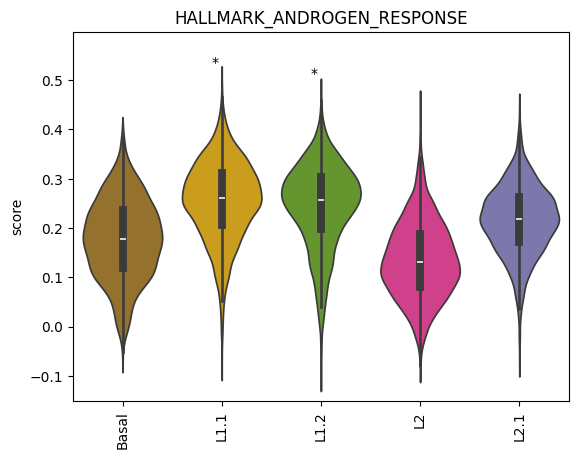

/tmp/ipykernel_64143/2270386978.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.violinplot(mtx,y='{}_score'.format(sig_name),x='subtype',palette=sns.color_palette('Dark2_r'))
/tmp/ipykernel_64143/2270386978.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  g=sns.violinplot(mtx,y='{}_score'.format(sig_name),x='subtype',palette=sns.color_palette('Dark2_r'))
/tmp/ipykernel_64143/2270386978.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(),rotation=90)


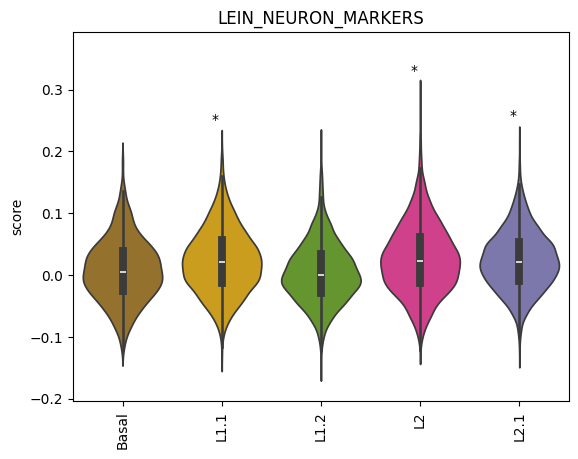

/tmp/ipykernel_64143/2270386978.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.violinplot(mtx,y='{}_score'.format(sig_name),x='subtype',palette=sns.color_palette('Dark2_r'))
/tmp/ipykernel_64143/2270386978.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  g=sns.violinplot(mtx,y='{}_score'.format(sig_name),x='subtype',palette=sns.color_palette('Dark2_r'))
/tmp/ipykernel_64143/2270386978.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(),rotation=90)


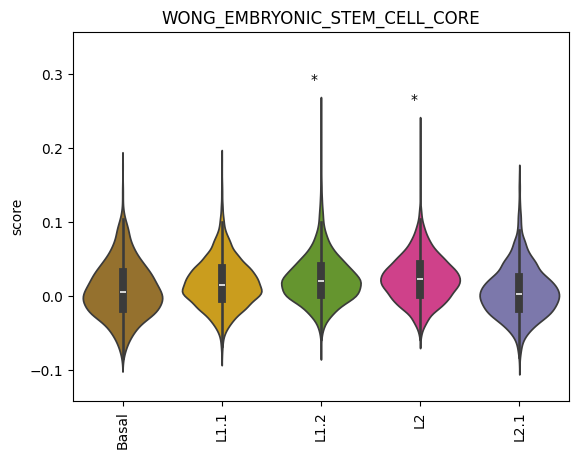

In [13]:
subtype_names = ['Basal','L1.1','L1.2','L2','L2.1']
for sig_name in sig_d.keys():
    g=sns.violinplot(mtx,y='{}_score'.format(sig_name),x='subtype',palette=sns.color_palette('Dark2_r'))
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    g.set_xlabel('')
    g.set_ylabel('score')
    g.set_title(sig_name)
    for i,annot in enumerate(sig_annot_d[f'{sig_name}_score']):
        subtype = subtype_names[i]
        plt.annotate(annot,(i-.1,max(mtx.query("subtype == @subtype")['{}_score'.format(sig_name)])+.03))
    plt.ylim(min(mtx['{}_score'.format(sig_name)])-.05,max(mtx['{}_score'.format(sig_name)])+.1)
    plt.show()

### UMAPs

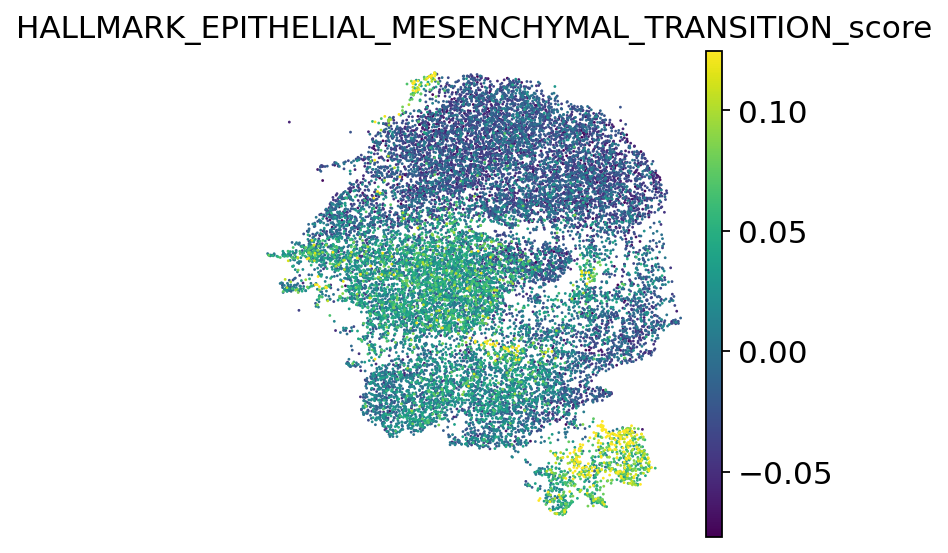

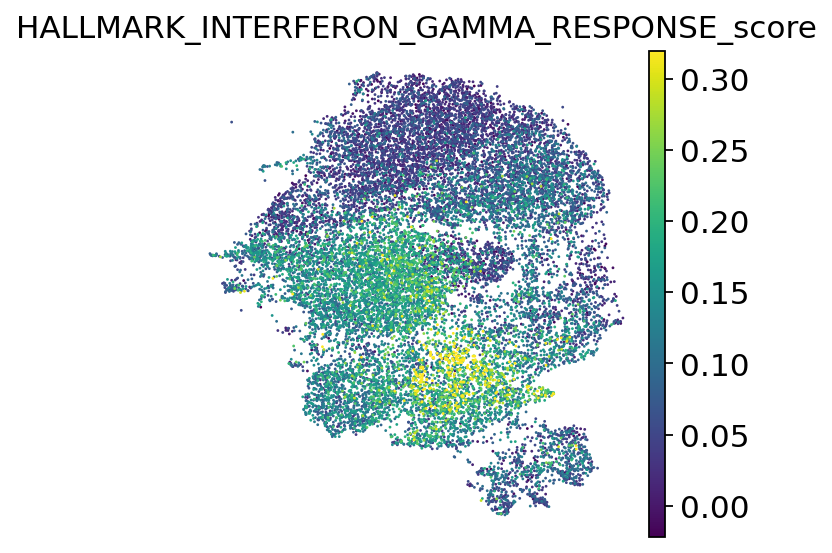

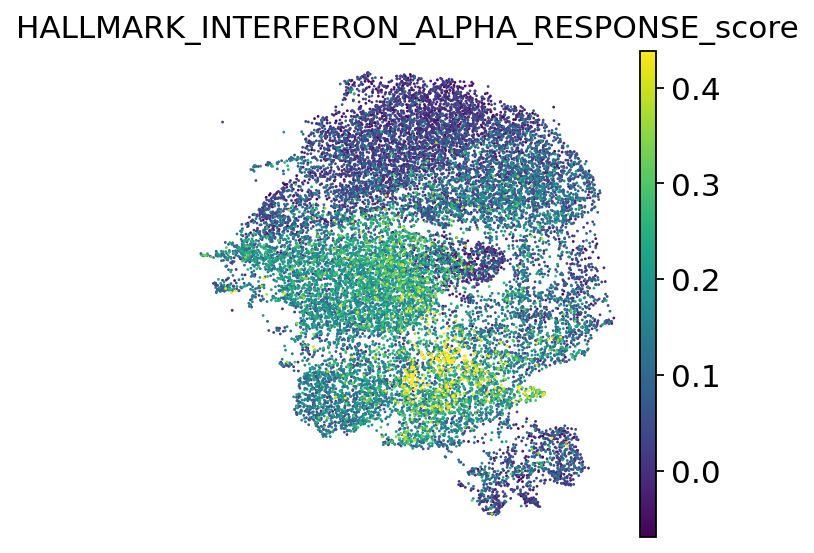

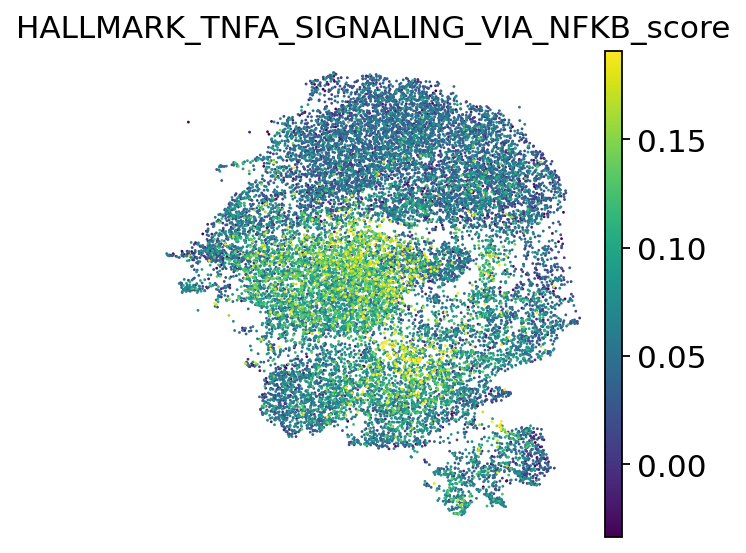

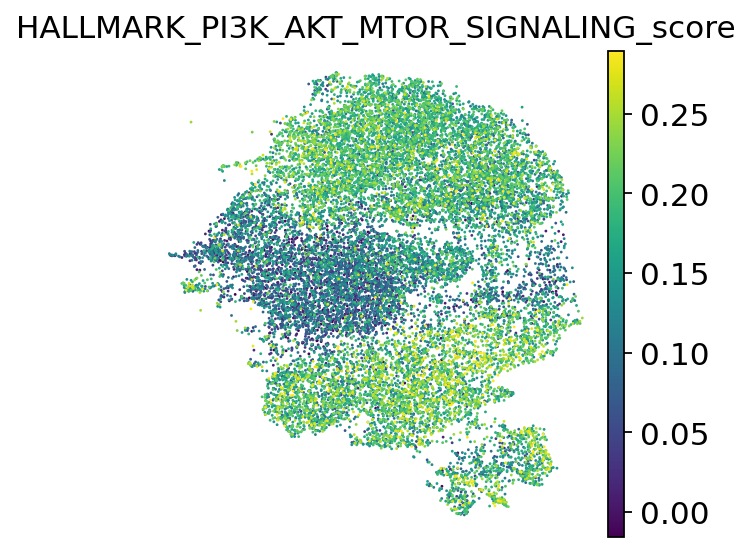

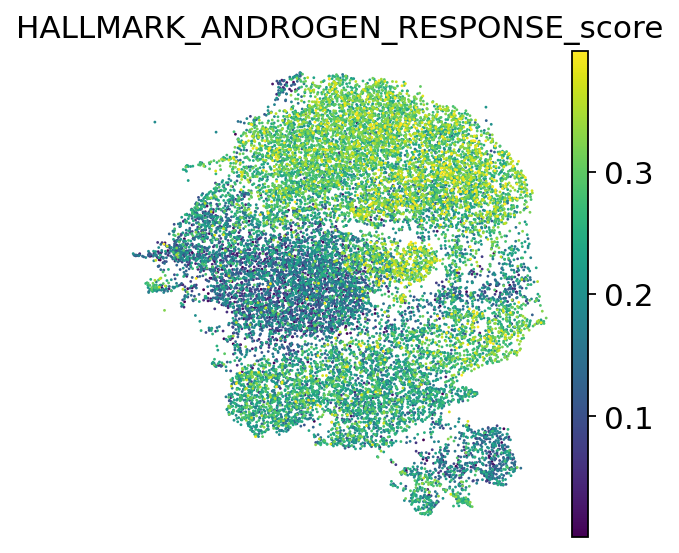

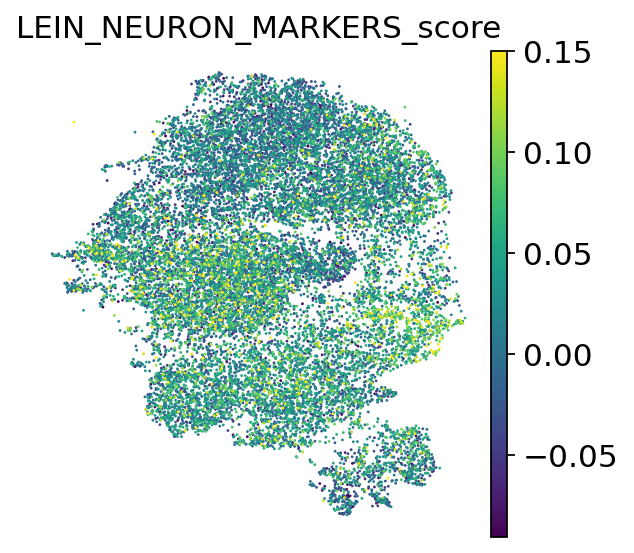

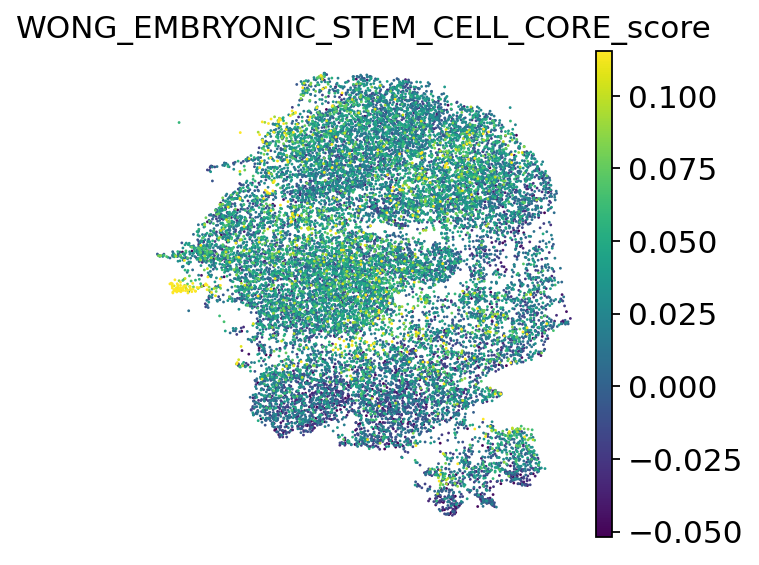

In [14]:
sc.settings.set_figure_params(dpi=80,dpi_save=300,facecolor='white',format='svg')
for key,item in sig_d.items():
    vmin = np.percentile(ep_ad.obs[f'{key}_score'],1)
    vmax = np.percentile(ep_ad.obs[f'{key}_score'],99)
    sc.pl.umap(ep_ad,color=f'{key}_score',vmin=vmin,vmax=vmax,frameon=False,use_raw=False)

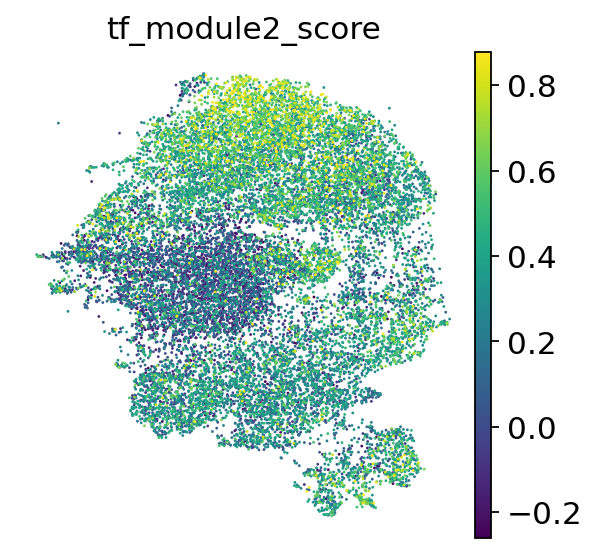

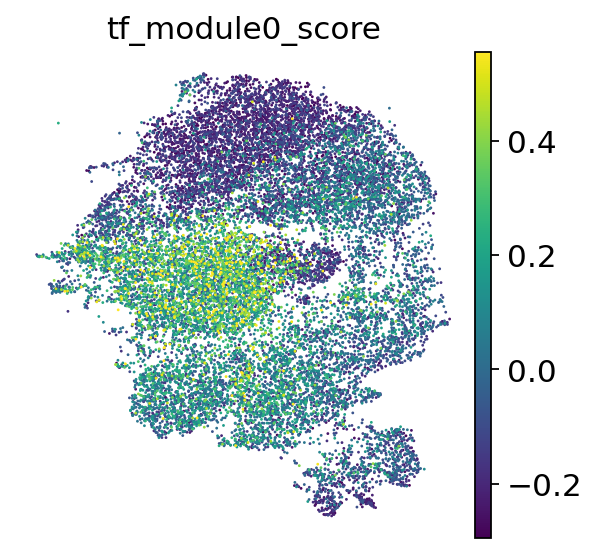

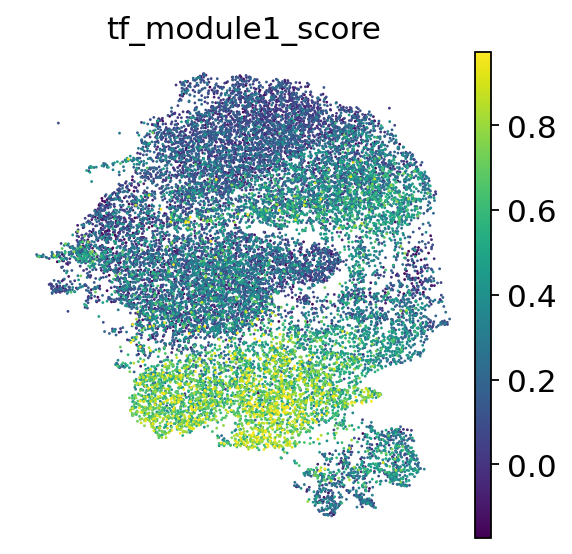

In [15]:
for module in sig_tf_modules.tf_module.unique():
    vmin = np.percentile(ep_ad.obs[f'tf_module{module}_score'],1)
    vmax = np.percentile(ep_ad.obs[f'tf_module{module}_score'],99)
    sc.pl.umap(ep_ad,color=f'tf_module{module}_score',vmin=vmin,vmax=vmax,frameon=False,use_raw=False)